<a href="https://colab.research.google.com/github/Ahtesham519/jupyter-notebook_python/blob/main/Praticle_nlp_ch4_one_pipeline_manyclassifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy 
!pip install pandas 
!pip install scikit-learn
!pip install matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


!note the stop_words library has been changed to _stop_words

In [2]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

#matplotlib imports are used here to plot confusion mertics for the classifiers
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#import feature extraction methods from sklearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

#pre-processing of text
import string 
import re 

#import classifiers from sklearn 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different mertics to evaluate the classifiers 
from sklearn.metrics import accuracy_score

#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#import time function from time module to track the training duration 
from time import time






Section -1 Load and explore the dataset

In [6]:
try:
  from google.colab import files 
  #!wget -P DATAPATH https://github.com/practical-nlp/practical-nlp-code/blob/c5afa8b5c32b57d17dad62303e44968b163d221d/Ch4/Data/Full-Economic-News-DFE-839861.csv
  #!ls -lah DATAPATH
  our_data = pd.read_csv("/content/DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1")

except ModuleNotFoundError:
  our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1")

In [7]:
display(our_data.shape)  #Number of rows (instances) and columns in the datasets 
our_data['relevance'].value_counts() / our_data.shape[0]    #Class distribution in the dataset 


(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [8]:
our_data = our_data[our_data.relevance != "not sure"]   #removing the data where we don't want relevence 
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes' :1 , 'no' :0})   #relevance is 1 , not-relevant is 0
our_data = our_data[["text" , "relevance"]]  #Let us take only the two columns we need 
our_data.shape

(7991, 2)

Section -2  Text Pre-processing

In [9]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def clean(doc):    #doc is a string of text
  doc = doc.replace("</br>" , " ")    #This text contains a lot of <br/> tags
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = " ".join([token for token in doc.split() if token not in _stop_words])

  #remove punctuation and numbers 
  return doc

Section-3 :Modeling 

In [10]:
import sklearn
#from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split

#Step-1: train-test split 
X = our_data.text    #the column text contains textual data to extract features from 
y = our_data.relevance #This is the column we are learning to predict 
print(X.shape, y.shape)

#split X and y into trainign and testing sets. By default , it splits 75% training and 25%test
#random_state = 1 for reproducibility

X_train, X_test , y_train , y_test = train_test_split(X, y, random_state=1)
print(X_train.shape , y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [11]:
#step 2-3 :Preprocess and Vectorize train and test data
vect = CountVectorizer()   #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)   #use it to extract features from training data.

#transform testing data (using training data's features )
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

#i.e the dimension of our feature vector is 49753! 


(5993, 39996) (1998, 39996)


Step-3: train the classifier and predict from test data 

In [12]:
nb = MultinomialNB()   #instantiate a Multinomial Naive Bayes model 
%time nb.fit(X_train_dtm, y_train)   #train the model (timing it with an IPython "magic Command")
y_pred_class = nb.predict(X_test_dtm )   #make class predictions for X_test_dtm

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 19.2 ms


Accuracy:  0.7542542542542543
ROC_AOC_SCORE:  0.720090155945419


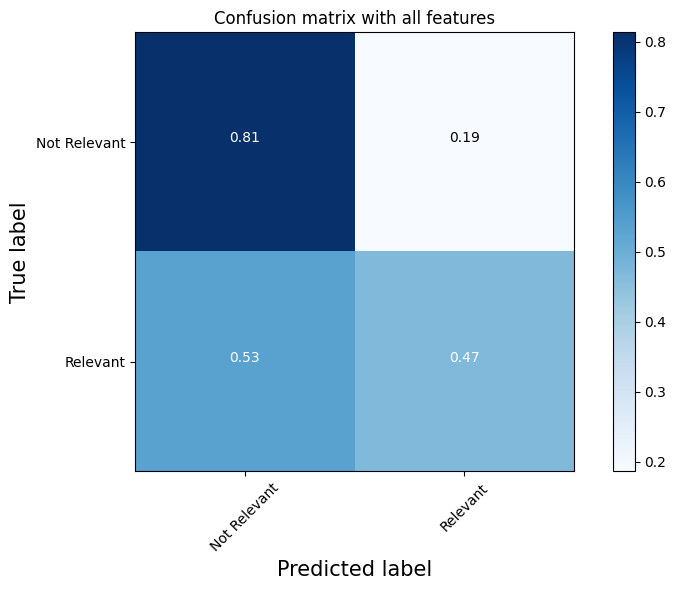

In [14]:
#step-4 Evaluate the classifier using various measures .

#Function to plot confusion matrix

import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes , 
                          normalize = False ,
                          title= 'Confusion matrix',
                          cmap = plt.cm.Blues):
  """This function prints and plots the confusion matrix .
  Normalization can be applied by setting 'normalizer = True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[: , np.newaxis]

  plt.imshow(cm, interpolation='nearest' , cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks , classes , rotation = 45)
  plt.yticks(tick_marks , classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2.
  for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
    plt.text(j , i , format(cm[i , j] , fmt) , 
             horizontalalignment = "center" , 
             color = "white" if cm[i , j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label' , fontsize = 15)
    plt.xlabel('Predicted label' , fontsize = 15)


#print accuracy:
print("Accuracy: " , accuracy_score(y_test , y_pred_class))

#print the confusion matrix
cnf_matrix = confusion_matrix(y_test , y_pred_class)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix , classes = ['Not Relevant' , 'Relevant'] , normalize = True,
                      title = 'Confusion matrix with all features')

#calculate AUC : 

y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_SCORE: " , roc_auc_score(y_test , y_pred_prob))


CPU times: user 4.74 ms, sys: 0 ns, total: 4.74 ms
Wall time: 4.75 ms
Accuracy:  0.6881881881881882


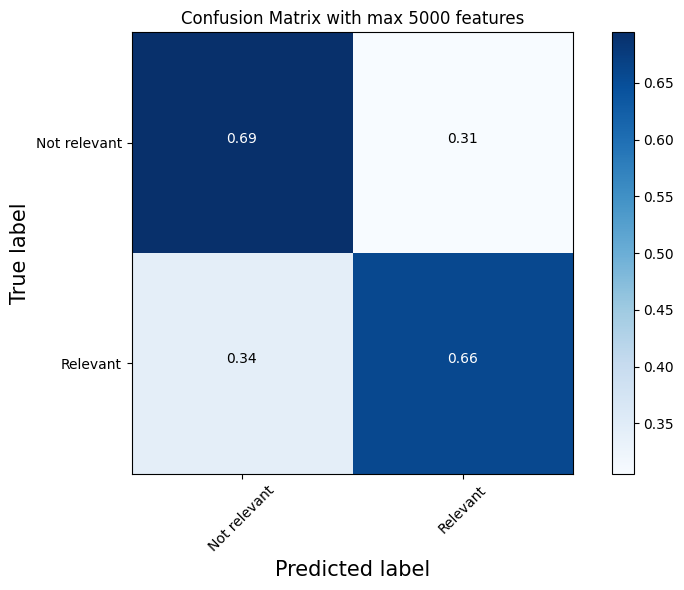

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as _stop_words
vect = CountVectorizer(preprocessor = clean , max_features=5000)  #Step-1
X_train_dtm = vect.fit_transform(X_train)  #Combined step-2 and step-3 
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()     #instantitate a multinomial Naive Bayes model . 
%time nb.fit(X_train_dtm , y_train)   #train the model (timing it with the IPython)
y_pred_class = nb.predict(X_test_dtm)   #make class predictions for X_test_dtm
print("Accuracy: " , metrics.accuracy_score(y_test, y_pred_class)) 

#print the confusion matrix 
cnf_matrix = confusion_matrix(y_test , y_pred_class)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix , classes= ['Not relevant' , 'Relevant'] , normalize = True,
                      title = "Confusion Matrix with max 5000 features")


Accuracy: 0.7427427427427428
AUC:  0.720090155945419


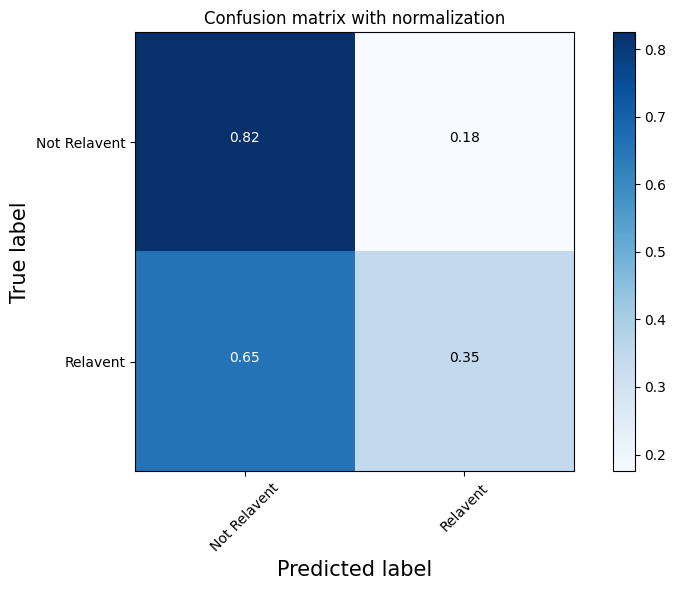

In [25]:
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression(class_weight="balanced")  #instantiate a Logistic Regression model 
logreg.fit(X_train_dtm , y_train)   #Fit the model with training data

#make the predictions on the test data
y_pred_class = logreg.predict(X_test_dtm)

#claculate evaluation measures:
print("Accuracy:" , accuracy_score(y_test , y_pred_class))
print("AUC: " , roc_auc_score(y_test , y_pred_prob))
cnf_matrix = confusion_matrix(y_test , y_pred_class)
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix , classes = ['Not Relavent' , 'Relavent' ] , normalize = True, 
                      title = 'Confusion matrix with normalization')

Accuracy :  0.6936936936936937
AUC:  0.720090155945419


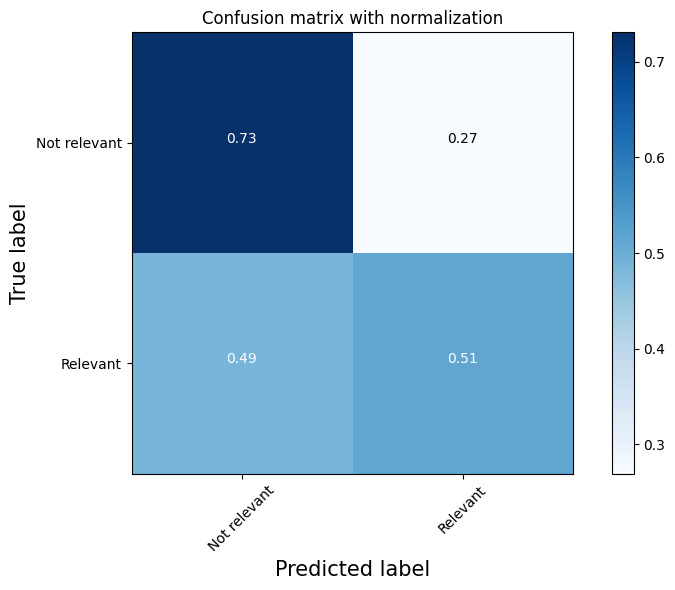

In [26]:
from sklearn.svm import LinearSVC
vect = CountVectorizer(preprocessor = clean , max_features = 1000)   #Step -1
X_train_dtm = vect.fit_transform(X_train)                #combined step-2 and step-3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight = 'balanced')    #instantiate a Logistic Regression model 
classifier.fit(X_train_dtm , y_train)    #fit the model with the training data 

#Make the prediction on the test data
y_pred_class = classifier.predict(X_test_dtm)


#calculate evaluation measures:
print("Accuracy : " , accuracy_score(y_test , y_pred_class))
print("AUC: " , roc_auc_score(y_test , y_pred_prob))

cnf_matrix = confusion_matrix(y_test , y_pred_class)

plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix , classes = ['Not relevant' , 'Relevant' ] , normalize = True , 
                      title = 'Confusion matrix with normalization')